# Chapter 04
### Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline

# read into dataframes
Batting = pd.read_csv('data/Batting.csv', index_col=['playerID', 'yearID'])
Pitching = pd.read_csv('data/Pitching.csv', index_col=['playerID', 'yearID'])
Master = pd.read_csv('data/Master.csv', index_col='playerID')

career = (Batting
          .query("AB > 0")
          .join(Pitching, how='left', rsuffix='_')
          .query("teamID_ != teamID_")  # IS NULL hack for `query` method -> only Batters
          .groupby(level=0)  # group by index -> playerID
          .agg({'H': np.sum, 'AB': np.sum})
          .assign(average = lambda x: x['H'] / x['AB'])
         )

career = (career
          .join(Master)
          .assign(name = lambda x: x['nameFirst'] + ' ' + x['nameLast'])
          [['name', 'H', 'AB', 'average']]  # select only columns we want
         )

# priors estimated in chapter 3
alpha0 = 75.88
beta0 = 216.69

eb_estimate_func = lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0)

career_eb = career.assign(eb_estimate=eb_estimate_func)

## Section 4.2 - Posterior Distribution

In [2]:
career_eb = career_eb.assign(alpha1 = lambda x: alpha0 + x['H'],
                             beta1 = lambda x: beta0 + x['AB'] - x['H'])
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69


### Figure 4.1

#### Setup: Yankees

In [3]:
drobs_fav_yankees = ['willibe02', 'strawda01','knoblch01',
                     'jeterde01', 'posadjo01', 'martiti02',
                     'brosisc01']

yankee_1998_career = career_eb.loc[drobs_fav_yankees].sort_index()
yankee_1998_career

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
brosisc01,Scott Brosius,1001,3889,0.257393,0.257530,1076.88,3104.69
jeterde01,Derek Jeter,3465,11195,0.309513,0.308236,3540.88,7946.69
knoblch01,Chuck Knoblauch,1839,6366,0.288878,0.287581,1914.88,4743.69
martiti02,Tino Martinez,1925,7111,0.270707,0.270259,2000.88,5402.69
posadjo01,Jorge Posada,1664,6092,0.273145,0.272513,1739.88,4644.69
strawda01,Darryl Strawberry,1401,5418,0.258583,0.258622,1476.88,4233.69
willibe02,Bernie Williams,2336,7869,0.296861,0.295517,2411.88,5749.69


Python doesn't have an equivalent of R's `qbeta` function. We'll have to roll our own.

In [4]:
# TODO: Change this to use np.beta
def qbeta(alpha, beta):
    """
    Generate the probability density function of the Beta
    distribution for a given alpha and beta.
    
    Parameters
    ----------
    alpha: float
    beta: float
    
    Returns
    -------
    tuple: x, Beta pdf
    """
    x = np.linspace(ss.beta.ppf(0.01, alpha, beta),
                    ss.beta.ppf(0.99, alpha, beta), num=100)
    return (x, ss.beta.pdf(x, alpha, beta))

It feels like there has to be a better way to do this. If you find one, let me know.

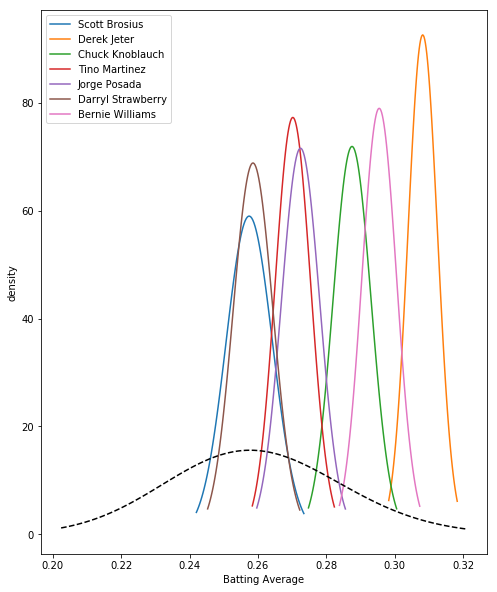

In [5]:
plt.figure(figsize=(8, 10))
for id_, row in yankee_1998_career.iterrows():
    plt.plot(*qbeta(row['alpha1'], row['beta1']), label=row['name'])

plt.plot(*qbeta(alpha0, beta0), 'k--')
plt.legend()
plt.xlabel('Batting Average')
plt.ylabel('density');

## Section 4.3 - Credible Intervals

In [6]:
def qbeta(alpha, beta_, q=50., size=10000):
    return np.percentile(beta(alpha, beta_, size=size), q=q)

### TODO: Figure 4.2
### TODO: Figure 4.3

In [7]:
yankee_1998_career = (
    yankee_1998_career
    .assign(low = lambda df: df.apply(lambda x: qbeta(x['alpha1'], x['beta1'], q=2.5), axis=1))
    .assign(high = lambda df: df.apply(lambda x: qbeta(x['alpha1'], x['beta1'], q=97.5), axis=1))
)

yankee_1998_career

,name,H,AB,average,eb_estimate,alpha1,beta1,low,high
playerID,,,,,,,,,
brosisc01,Scott Brosius,1001,3889,0.257393,0.257530,1076.88,3104.69,0.244244,0.270904
jeterde01,Derek Jeter,3465,11195,0.309513,0.308236,3540.88,7946.69,0.299789,0.316680
knoblch01,Chuck Knoblauch,1839,6366,0.288878,0.287581,1914.88,4743.69,0.276539,0.298585
martiti02,Tino Martinez,1925,7111,0.270707,0.270259,2000.88,5402.69,0.260127,0.280295
posadjo01,Jorge Posada,1664,6092,0.273145,0.272513,1739.88,4644.69,0.261575,0.283693
strawda01,Darryl Strawberry,1401,5418,0.258583,0.258622,1476.88,4233.69,0.247376,0.270415
willibe02,Bernie Williams,2336,7869,0.296861,0.295517,2411.88,5749.69,0.285621,0.305538


## Section 4.4 - Credible Intervals and Confidence Intervals

### TODO: Figure 4.4